In [1]:
from utils import *

import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns
import folium

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, accuracy_score

import optuna
from optuna.trial import TrialState

/home/guilhermemaciel/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Carregando o dataset

In [2]:
df_train = pd.read_csv('../data/treated_data/train.csv')
df_val = pd.read_csv('../data/treated_data/validation.csv')
df_test = pd.read_csv('../data/treated_data/test.csv')

In [3]:
df_submit = pd.read_csv('../data/submit/Resultados_EquipeX_Metodo_Y.csv')

Concatenando os datasets de treino e validação, pois o Random Forest não necessita de validação

In [4]:
df_train = pd.concat([df_train, df_val], ignore_index=False)

In [5]:
df_train.head()

,ponto_id,rssi_1_1,rssi_1_2,rssi_1_3,rssi_2_1,rssi_2_2,rssi_2_3,rssi_3_1,rssi_3_2,rssi_3_3,delay_1,delay_2,delay_3,lat,lon,indoor
0,7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.317523,0.527387,0.000000,0.666667,0.428571,0.285714,-8.055605,-34.951728,1
1,5532,0.182301,0.000000,0.180096,0.000000,0.171053,0.000000,0.291003,0.352840,0.110150,0.666667,0.428571,0.285714,-8.055784,-34.951608,1
2,9607,0.456080,0.551300,0.418441,0.257431,0.403415,0.426501,0.336851,0.464357,0.326409,0.333333,0.428571,0.857143,-8.046460,-34.946220,0
3,8265,0.532237,0.460564,0.534400,0.503367,0.787234,0.538737,0.332463,0.405254,0.278578,0.500000,0.142857,0.571429,-8.051810,-34.948510,0
4,8008,0.536607,0.579895,0.498791,0.624933,0.614968,0.256754,0.452570,0.417102,0.278578,0.500000,0.142857,0.571429,-8.052220,-34.948150,0


In [6]:
X_train = df_train.drop(['ponto_id', 'indoor', 'lat', 'lon'], axis=1).values
y_train = df_train[['lat', 'lon']].values

X_test = df_test.drop(['ponto_id', 'indoor', 'lat', 'lon'], axis=1).values
y_test = df_test[['lat', 'lon']].values

In [7]:
model = RandomForestRegressor(
    n_estimators=483,
    max_depth=17,
    criterion='squared_error',
    min_samples_leaf=1,
    min_samples_split=2,
    max_features=df_train.shape[1],
    random_state=51
)

In [8]:
model.fit(X=X_train, y=y_train)

RandomForestRegressor(max_depth=17, max_features=16, n_estimators=483,
                      random_state=51)

## Avaliando o modelo

#### Conjunto de Teste

In [9]:
y_pred_test_class = model.predict(X_test)

rmse = np.sqrt(root_mean_squared_error(y_test, y_pred_test_class))
print(f'RMSE: {rmse}')

RMSE: 0.010488167559335774


In [10]:
accuracy = calculate_accuracy(y_pred_test_class, y_test, threshold=0.001)
print(f"Acurácia: {accuracy:.3f}")


Acurácia: 0.994


In [11]:
model.score(X_test, y_test)

0.9977275449760032

Erro de localização médio, mínimo, máximo e desvio-padrão

In [12]:
distances = get_error_distances(y_pred_test_class, y_test)

In [13]:
print_errors(distances)

Erro de localização médio: 5.847 metros
Erro mínimo: 1.4146461779773745e-09 metros
Erro máximo: 173.553 metros
Desvio Padrão do erro: 16.282 metros


#### BoxPlot

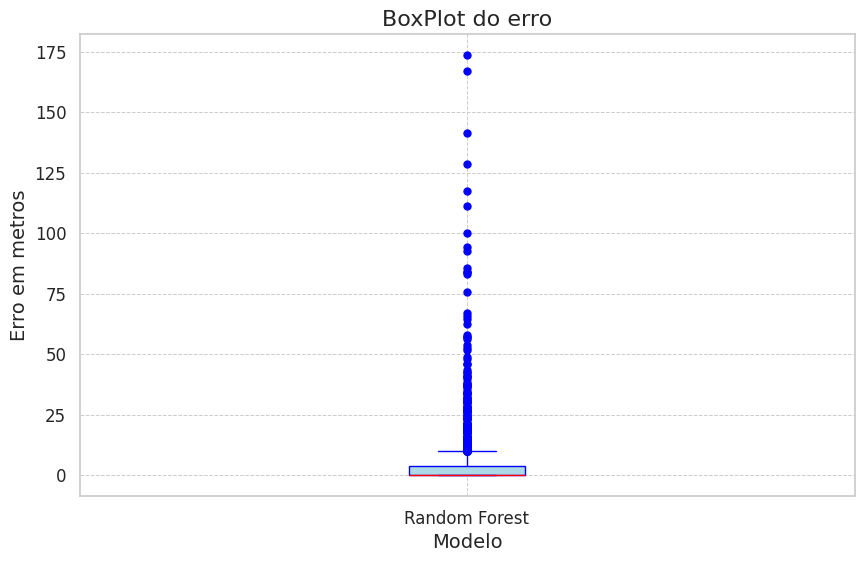

In [14]:
plot_boxplot('Random Forest', distances)

#### Histograma dos Erros

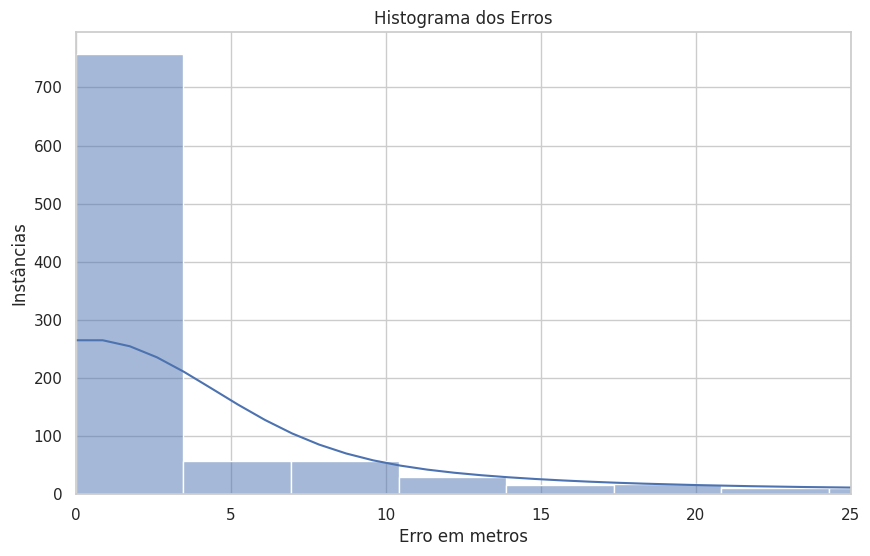

In [15]:
plot_histogram(distances)

In [16]:
print(f"Total de distâncias: {len(distances)}")
print(f"Distâncias com menos de 25 Metros de erro: {np.sum(distances <= 25)}")

Total de distâncias: 1018
Distâncias com menos de 25 Metros de erro: 948


#### Criação do arquivo de submit

In [17]:
submit = df_submit.copy()
submit

,ponto_id,rssi_1_1,rssi_1_2,rssi_1_3,rssi_2_1,rssi_2_2,rssi_2_3,rssi_3_1,rssi_3_2,rssi_3_3,delay_1,delay_2,delay_3
0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.317523,0.527387,0.000000,0.571429,0.428571,0.285714
1,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.317523,0.527387,0.000000,0.571429,0.428571,0.285714
2,8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.317523,0.494311,0.000000,0.571429,0.428571,0.285714
3,10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.317523,0.527387,0.000000,0.571429,0.428571,0.285714
4,12,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.317523,0.527387,0.000000,0.571429,0.428571,0.285714
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2899,9672,0.683007,0.427860,0.745375,0.338093,0.372425,0.513271,0.344011,0.199565,0.284662,0.000000,0.571429,0.571429
2900,9674,0.660574,0.614986,0.745375,0.265625,0.373545,0.378663,0.344011,0.199565,0.280179,0.000000,0.571429,0.571429
2901,9675,0.696515,0.272818,0.650478,0.293126,0.272255,0.369109,0.400705,0.199565,0.298351,0.000000,0.571429,0.571429
2902,9677,0.701844,0.508683,0.657285,0.240302,0.295898,0.347393,0.379110,0.199565,0.330972,0.000000,0.571429,0.714286


In [18]:
df_submit = df_submit.drop(['ponto_id'], axis=1)

In [20]:
y_pred_test_class = model.predict(df_submit.values)


In [21]:
submit['lat_pred'] = y_pred_test_class[:, 0]
submit['lon_pred'] = y_pred_test_class[:, 1]


In [23]:
submit.drop([
    'rssi_1_1', 'rssi_1_2', 'rssi_1_3',
    'rssi_2_1', 'rssi_2_2', 'rssi_2_3',
    'rssi_3_1', 'rssi_3_2', 'rssi_3_3',
    'delay_1', 'delay_2', 'delay_3'
], axis=1, inplace=True)

In [24]:
submit

,ponto_id,lat_pred,lon_pred
0,0,-8.051945,-34.949127
1,3,-8.051945,-34.949127
2,8,-8.051945,-34.949127
3,10,-8.051945,-34.949127
4,12,-8.051945,-34.949127
...,...,...,...
2899,9672,-8.046723,-34.952417
2900,9674,-8.046543,-34.952324
2901,9675,-8.046449,-34.952703
2902,9677,-8.046444,-34.951807


In [25]:
submit.to_csv(f'../data/submit/Resultados_Equipe5_Metodo_RandomForestRegressor.csv', index=False)

#### Visualização dos Mapas

In [ ]:
map = plot_folium_map(y_test, y_pred_test_class, True)
map

In [ ]:
map = plot_folium_map(y_test, y_pred_test_class, False)
map

#### Avaliando o modelos para pontos específicos 

In [ ]:
# Prevendo o valor de uma instância específica
idx = 75

X_unit = X_test[idx].reshape(1, -1)
y_unit = np.array([y_test[idx]])
y_pred_unit = model.predict(X_unit)

print(f"Pred Point: {y_pred_unit[0]}")
print(f"Real Point: {y_unit[0]}")

In [ ]:
map = plot_folium_map(y_unit, y_pred_unit, True)
map

#### Usando o Optune para encontrar os melhores Hiperparâmetros

#### Primeiro iremos criar uma função objetivo, com foco em maximizar o AOC

In [ ]:
def objective(trial):

    global x_train
    global y_train

    global X_test
    global y_test
    
    # Sugerir valores para os hiperparâmetros
    n_estimators = trial.suggest_int('n_estimators', 10, 500)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 15)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)

    trial.set_user_attr("n_estimators", n_estimators)
    trial.set_user_attr("max_depth", max_depth)
    trial.set_user_attr("min_samples_split", min_samples_split)
    trial.set_user_attr("min_samples_leaf", min_samples_leaf)
    
    # Criar o modelo RandomForest com os hiperparâmetros sugeridos
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=51,
        criterion='squared_error',
    )

    model.fit(X=X_train, y=y_train)
    
    # Avaliar o modelo usando test k-s
    y_pred_test_class = model.predict(X_test)
    rmse = np.sqrt(root_mean_squared_error(y_test, y_pred_test_class))
    accuracy = calculate_accuracy(y_pred_test_class, y_test)
    
    print(f'\n\nRandom Forest\nn_estimators: {n_estimators}\nmax_depth:{max_depth}\nmin_samples_split:{min_samples_split}\nmin_samples_leaf:{min_samples_leaf}')
    print(f'RMSE: {rmse}\nAccuracy: {accuracy:.3f}')
    

    trial.set_user_attr("RMSE", rmse)
    trial.set_user_attr("Accuracy", accuracy)
    
    return rmse


In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

#### Salvando os resultados no csv e visualizando os resultados

In [ ]:
df = study.trials_dataframe()
df = df[df["state"] == "COMPLETE"].drop(["datetime_start", "datetime_complete", "duration", "state"], axis=1)
df = df.sort_values(['value']) 

csv_file = "optuna_results_rf.csv"
df_existing = pd.read_csv(csv_file) if os.path.isfile(csv_file) else None

df_existing = pd.concat([df_existing, df], ignore_index=True) if df_existing is not None else df
df_existing.to_csv(csv_file, index=False)

In [ ]:
df_existing

In [ ]:
best_trial = study.best_trials[0]
print("\n-- Best Trial --")
print(f"  RMSE:  {best_trial.user_attrs['RMSE']}")
print(f"  Accuracy: {best_trial.user_attrs['Accuracy']}")

print("  Parameters: ")
for key, val in best_trial.params.items():
    print(f"    {key}: {(16 - len(key)) * ' '}{val}")


print(f"\n-- Overall Results (Ordered by auroc) --")
print(df)

most_important_parameters = optuna.importance.get_param_importances(best_trial)

print("\n-- Most Important Hyperparameters --")
for key, val in most_important_parameters.items():
    print(f"  {key}: {(15 - len(key)) * ' '}{(100 * val):.2f}%")